In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
import math

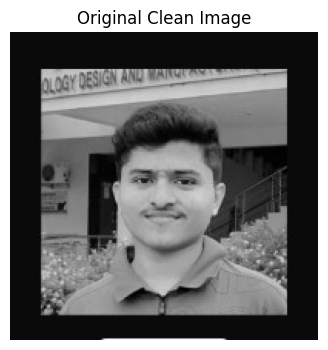

In [8]:
def show(img, title=""):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()

original_img = cv2.imread('img.jpeg', cv2.IMREAD_GRAYSCALE)
show(original_img, "Original Clean Image")

# **Assignment 1 : Gaussian Noise Removal using Arithmetic Mean Filter**


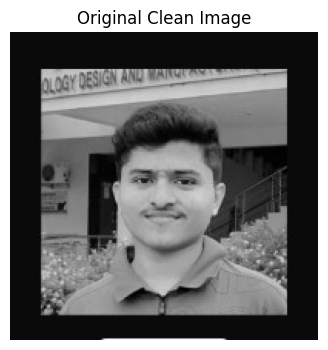

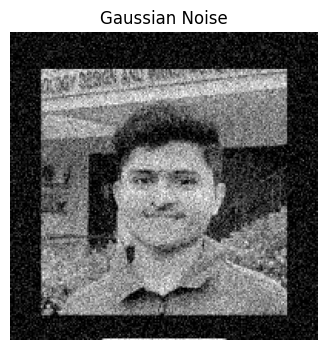

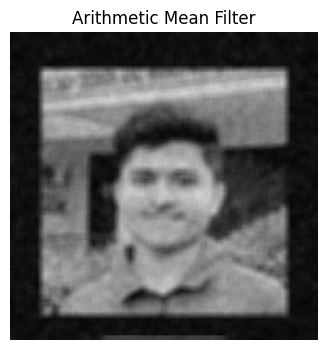

In [10]:
noisy_gauss = random_noise(original_img, mode='gaussian', mean=0, var=0.01) # add gaussian noise
noisy_gauss = (noisy_gauss * 255).astype(np.uint8)

filtered_arithmetic = cv2.blur(noisy_gauss, (5,5))  # mean filter

show(original_img, "Original Clean Image")
show(noisy_gauss, "Gaussian Noise")
show(filtered_arithmetic, "Arithmetic Mean Filter")

# **Assignment 2 : Gaussian Noise Removal using Geometric Mean Filter**

We do the calculation in log to avoid the unstability which comes to raising to powers. Instead calcuate in log and then raise it to e.


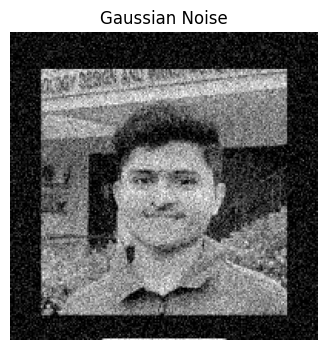

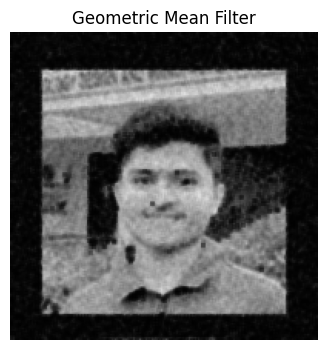

In [11]:
def geometric_mean_filter(img, k=3):
    img = img.astype(np.float32) + 1.0
    kernel = np.ones((k,k))

    log_img = np.log(img)
    filtered_log = cv2.filter2D(log_img, -1, kernel)

    return np.exp(filtered_log / (k*k)).astype(np.uint8)

filtered_geometric = geometric_mean_filter(noisy_gauss, k=3)
show(noisy_gauss, "Gaussian Noise")
show(filtered_geometric, "Geometric Mean Filter")

# **Assignment 3 : Salt Noise Removal using Harmonic Mean Filter**


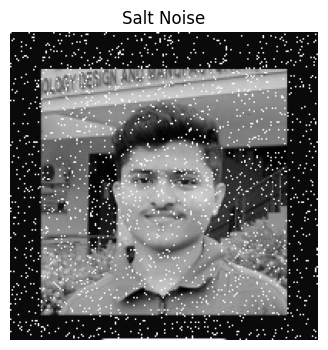

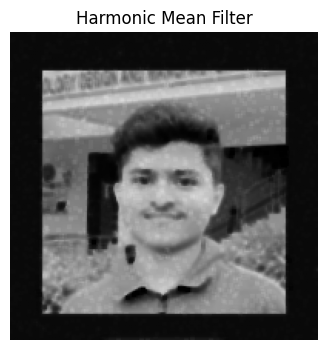

In [12]:
def harmonic_mean_filter(img, k=3):
    img = img.astype(np.float32)
    kernel = np.ones((k,k))

    denom = cv2.filter2D(1.0 / (img + 1e-6), -1, kernel)
    output = (k*k) / (denom + 1e-6)
    return output.astype(np.uint8)

salt_noisy = random_noise(original_img, mode='salt', amount=0.05)
salt_noisy = (salt_noisy * 255).astype(np.uint8)

filtered_harmonic = harmonic_mean_filter(salt_noisy, k=3)

show(salt_noisy, "Salt Noise")
show(filtered_harmonic, "Harmonic Mean Filter")

# **Assignment 4 : Pepper Noise Removal using Contraharmonic Mean Filter**


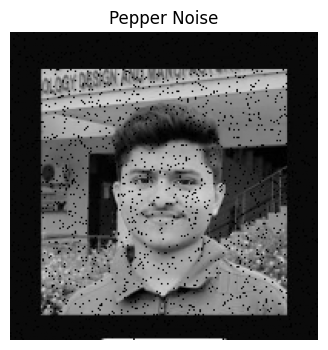

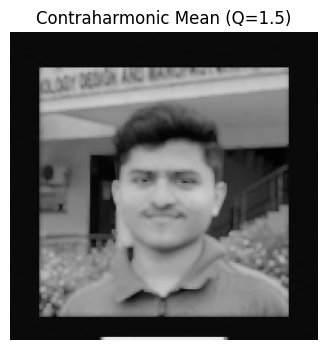

In [13]:
def contraharmonic_mean(img, k=3, Q=1.5):
    img = img.astype(np.float32)
    kernel = np.ones((k,k))

    num = cv2.filter2D(img**(Q+1), -1, kernel)
    den = cv2.filter2D(img**Q + 1e-6, -1, kernel)

    return (num / den).astype(np.uint8)

pepper_noisy = random_noise(original_img, mode='pepper', amount=0.05)
pepper_noisy = (pepper_noisy * 255).astype(np.uint8)

filtered_contra = contraharmonic_mean(pepper_noisy, k=3, Q=1.5) # Q = +1.5 -> pepper
show(pepper_noisy, "Pepper Noise")
show(filtered_contra, "Contraharmonic Mean (Q=1.5)")

# **Assignment 5 : Salt-and-Pepper Noise Removal using Median Filter**

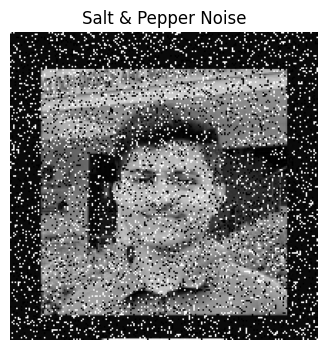

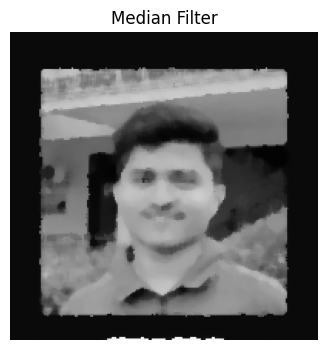

In [14]:
sp_noisy = random_noise(original_img, mode='s&p', amount=0.2)
sp_noisy = (sp_noisy * 255).astype(np.uint8)

filtered_median = cv2.medianBlur(sp_noisy, 5)

show(sp_noisy, "Salt & Pepper Noise")
show(filtered_median, "Median Filter")

# **Assignment 6 : Compare Min and Max Filters on Salt & Pepper Noise**


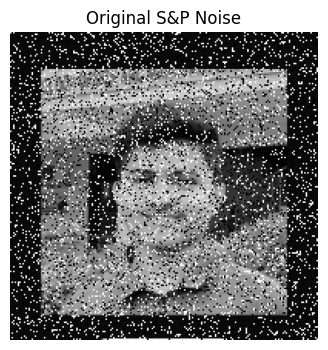

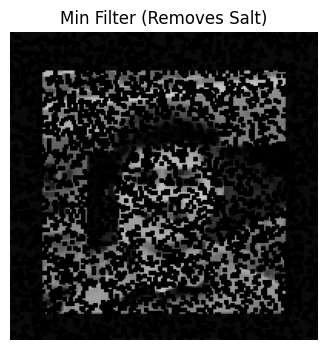

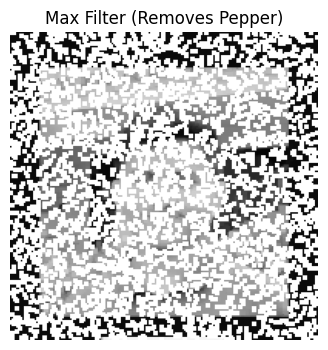

In [15]:
kernel_minmax = np.ones((3,3), np.uint8)

# Min Filter (Erosion) -> Removes Salt (White), worsens Pepper
min_filtered = cv2.erode(sp_noisy, kernel_minmax)

# Max Filter (Dilation) -> Removes Pepper (Black), worsens Salt
max_filtered = cv2.dilate(sp_noisy, kernel_minmax)

show(sp_noisy, "Original S&P Noise")
show(min_filtered, "Min Filter (Removes Salt)")
show(max_filtered, "Max Filter (Removes Pepper)")

# **Assignment 7 : Alpha-Trimmed Mean Filter for Mixed Noise**


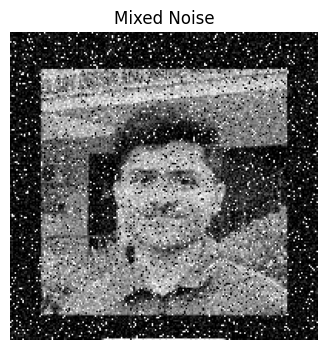

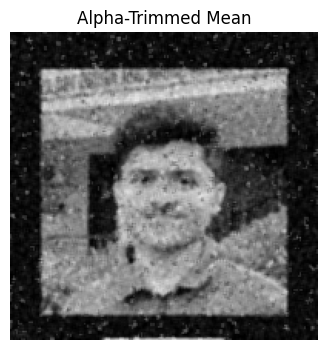

In [16]:
from scipy.ndimage import generic_filter

def alpha_trimmed_mean(buffer, d):
    sorted_pixels = np.sort(buffer)
    trim_start = int(d / 2)
    trim_end = int(len(buffer) - d / 2)

    remaining = sorted_pixels[trim_start:trim_end]
    return np.mean(remaining)

noisy_mixed = random_noise(original_img, mode='gaussian', mean=0, var=0.01)
noisy_mixed = random_noise(noisy_mixed, mode='s&p', amount=0.1)
noisy_mixed = (noisy_mixed * 255).astype(np.uint8)

filtered_alpha = generic_filter(noisy_mixed, alpha_trimmed_mean, footprint=np.ones((3,3)), extra_arguments=(2,))

show(noisy_mixed, "Mixed Noise")
show(filtered_alpha.astype(np.uint8), "Alpha-Trimmed Mean")

# **Assignment 8**


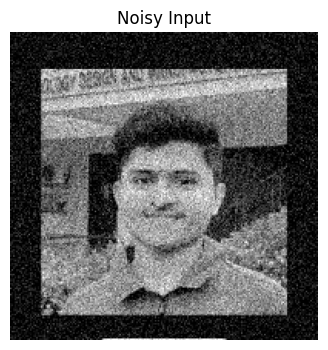

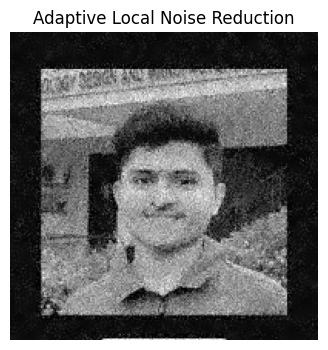

In [17]:
def adaptive_local_noise_reduction(img, var_noise_est=100, k=7):
    img = img.astype(np.float32)

    local_mean = cv2.blur(img, (k,k))

    local_sqR_mean = cv2.blur(img**2, (k,k))
    local_var = local_sqR_mean - local_mean**2
    local_var = np.maximum(local_var, 0.1) # Avoid 0 variance

    factor = var_noise_est / local_var
    factor = np.minimum(factor, 1.0) # Ratio cannot exceed 1

    output = img - factor * (img - local_mean)
    return output.astype(np.uint8)

filtered_adaptive = adaptive_local_noise_reduction(noisy_gauss, var_noise_est=200, k=7)

show(noisy_gauss, "Noisy Input")
show(filtered_adaptive, "Adaptive Local Noise Reduction")

# **Assignment 9**


Window 3x3 -> PSNR: 35.22 dB
Window 5x5 -> PSNR: 34.06 dB
Window 7x7 -> PSNR: 33.44 dB


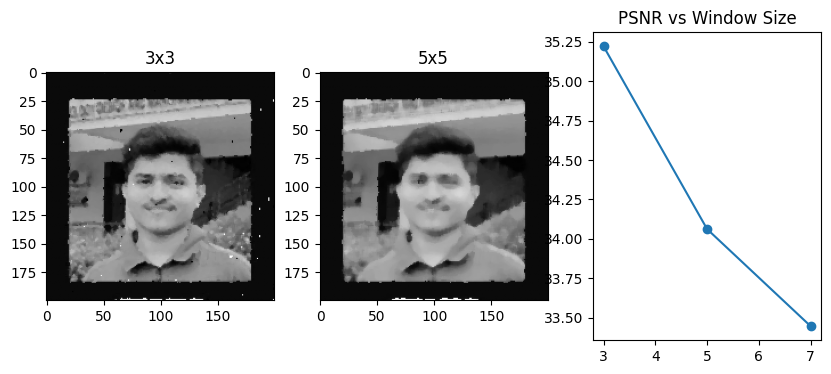

In [18]:
def calculate_psnr(orig, filtered):
    mse = np.mean((orig - filtered) ** 2)
    if mse == 0: return 100
    return 20 * math.log10(255.0 / math.sqrt(mse))

window_sizes = [3, 5, 7]
psnr_values = []
filtered_images = []

for k in window_sizes:
    f = cv2.medianBlur(sp_noisy, k)
    psnr = calculate_psnr(original_img, f)
    psnr_values.append(psnr)
    filtered_images.append(f)
    print(f"Window {k}x{k} -> PSNR: {psnr:.2f} dB")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(filtered_images[0], cmap='gray'); plt.title("3x3")
plt.subplot(1,3,2); plt.imshow(filtered_images[1], cmap='gray'); plt.title("5x5")
plt.subplot(1,3,3); plt.plot(window_sizes, psnr_values, marker='o'); plt.title("PSNR vs Window Size")
plt.show()

# **Assignment 10**


--- Test 1 ---
Impulse Ratio: 0.1511
Detected: Salt & Pepper Noise -> Applying Median Filter


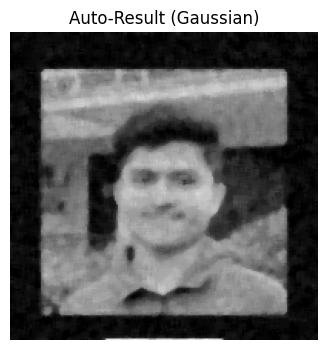


--- Test 2 ---
Impulse Ratio: 0.1972
Detected: Salt & Pepper Noise -> Applying Median Filter


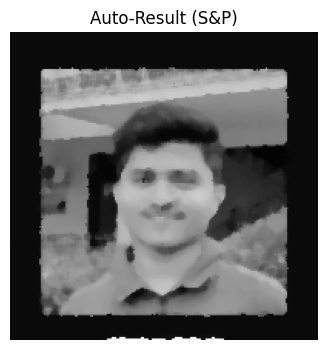

In [19]:
def automatic_denoising(img):
    flat = img.flatten()

    zeros = np.sum(flat == 0)
    maxs = np.sum(flat == 255)
    total = flat.size

    impulse_ratio = (zeros + maxs) / total

    print(f"Impulse Ratio: {impulse_ratio:.4f}")

    if impulse_ratio > 0.05:
        print("Detected: Salt & Pepper Noise -> Applying Median Filter")
        return cv2.medianBlur(img, 5)
    else:
        print("Detected: Gaussian/Speckle Noise -> Applying Arithmetic Mean")
        return cv2.blur(img, (5,5))

print("--- Test 1 ---")
res1 = automatic_denoising(noisy_gauss)
show(res1, "Auto-Result (Gaussian)")

print("\n--- Test 2 ---")
res2 = automatic_denoising(sp_noisy)
show(res2, "Auto-Result (S&P)")
